In [1]:
import astropy 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import ascii

#Module that pixelates and histograms in the range of ra_zoom (right ascention) and
#dec_zoom (declination) at the resolution of n_bins. Returns a tuple of 
#the pixel values (summed flux in that bin), the pixel centers in ra, and the pixel
#centers in dec.
def pixelate(ra_zoom, dec_zoom, n_bins, ra_overall, dec_overall, eye_overall, flux_overall):

    #Check to see which dimension is larger so that a square in ra,dec can 
    #be returned
    if (ra_zoom[1]-ra_zoom[0]) > (dec_zoom[1]-dec_zoom[0]):
        zoom = ra_zoom
    else:
        zoom = dec_zoom

    #Find the size of the bins using the largest dimension and the num of bins
    binsize = (zoom[1]-zoom[0])/n_bins

    #Create arrays for ra and dec that give the left side of each pixel
    ra_bin_array = np.multiply(range(n_bins), binsize) + ra_zoom[0]
    dec_bin_array = np.multiply(range(n_bins), binsize) + dec_zoom[0]

    #Create an empty array of pixels to be filled in the for loops
    pixels = np.zeros((len(ra_bin_array),len(dec_bin_array)))

    #Histogram components into ra bins
    ra_histogram = np.digitize(ra_overall,ra_bin_array)

    #Begin for loop over both dimensions of pixels, starting with ra
    for bin_i in range(len(ra_bin_array) - 2):

        #Find the indices that fall into the current ra bin slice
        ra_inds = np.where(ra_histogram == bin_i)

        #Go to next for cycle if no indices fall into current ra bin slice
        if len(ra_inds) == 0:
            continue

        #Histogram components that fall into the current ra bin slice by dec
        dec_histogram = np.digitize(dec_overall[ra_inds],dec_bin_array)

        #Begin for loop by dec over ra bin slice
        for bin_j in range(len(dec_bin_array) -2):
            
            #Find the indicies that fall into the current dec bin
            dec_inds = np.where(dec_histogram == bin_j)

            #Go to next for cycle if no indices fall into current dec bin			
            if len(dec_inds) == 0:
                continue

            #Sum the flux components that fall into current ra/dec bin
            pixels[bin_i,bin_j] = np.sum(flux_overall[(ra_inds[0])[dec_inds[0]]])

    #Find the pixel centers in ra/dec for plotting purposes
    ra_pixel_centers = np.multiply(range(n_bins),binsize) + ra_zoom[0] + binsize/2.
    dec_pixel_centers = np.multiply(range(n_bins),binsize) + dec_zoom[0] + binsize/2.

    return pixels, ra_pixel_centers, dec_pixel_centers

In [2]:
#This opened the file with the gps seconds and assigned them to a variable
oct24_obsids_file = open('/astro/users/bergea4/radio-eyes/Oct24_obsids.txt', 'r')
#This read every name sequentially, took out white space, and put the file into an array called aug23
oct24 = [line.split( ) for line in oct24_obsids_file.readlines()]

#This is a general code to go through each fits file, and then compacted everything into a single numpy array
for i in oct24:
    filename = '/astro/users/bergea4/Documents/Oct24_low_EoR1/' + i[0] + '_lowEoR1.fits'
    #header dater unit list- package from astropy to open file
    hdu_list = fits.open(filename)
    #pulls out actual data from hdu
    data = hdu_list[1].data[0]
    #id random interger
    eye = data[0]
    #declanation random interger
    dec = data[1]
    #right ascension of the component
    ra = data[2]
    #the flux density of the component woooo
    flux = data[3]
    #Given the array ra, execute the condition if an element is greater than 180. Reset that element to that 
    #element minus 360.
    #This only works on numpy arrays
    ra[ra>180] -= 360
    #This loops through the elements of the first fits file and sets them equal to an overall variable
    #Had to rename them because original variable names get overwritten
    if oct24[0] == i:
        ra_overall = ra
        dec_overall = dec
        eye_overall = eye
        flux_overall = flux
    #for all else, it appends to the new variable to make a REALLY BIG ARRAY OF EVERYTHING EVER
    else:
        ra_overall = np.append(ra_overall, ra)
        dec_overall = np.append(dec_overall, dec)
        eye_overall = np.append(eye_overall, eye)
        flux_overall = np.append(flux_overall, flux)

In [3]:
n_obs = len(oct24)

In [8]:
ra_zoom = [49.5, 52]
dec_zoom = [-38, -39]
n_bins = 165

In [9]:
#this takes a while to run so we're keeping it separate from the plotting cell so we only have to run it once
(pixels, ra_pixel_centers, dec_pixel_centers) = pixelate(ra_zoom, dec_zoom, n_bins, ra_overall, dec_overall, eye_overall, flux_overall)

In [10]:
pix23 = fits.getdata("oct23.fits")

In [12]:
diff = pix23 - pixels

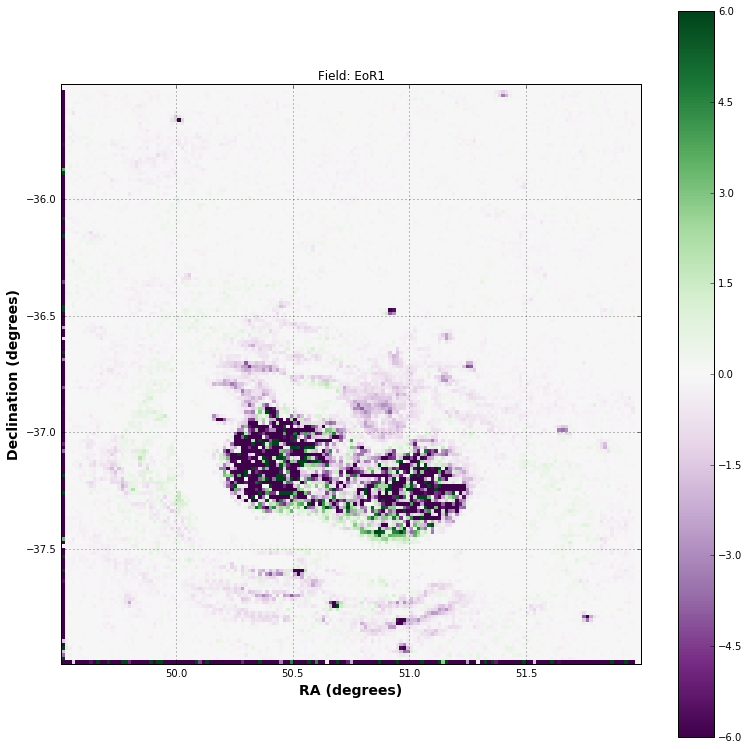

In [21]:
import matplotlib.pyplot as plt

#this makes the thing bigger!!
plt.figure(figsize=(13,13))

#imshow is a type of plot that shows the image (duh)
#took the log of the flux scale which made things happen
#interpolation made the pixels not fuzzy
#origin reoriented the y axis so it goes from 0 to 100 instead of 100 to 0
#cmap changed the colorbar so that the colors are sequentially dark-light in relation to flux

cmap = plt.cm.PRGn
cmap.set_bad('k')
plt.imshow(np.transpose(diff), interpolation = "nearest", origin = "lower", cmap = cmap, 
           extent = [ra_pixel_centers[0], ra_pixel_centers[len(ra_pixel_centers)-1], 
           dec_pixel_centers[0], dec_pixel_centers[len(dec_pixel_centers)-1]])


#the x and y axis labels are not accurate right now but that's okay :)
plt.xlabel('RA (degrees)', 
           fontweight='bold', size=14)
plt.ylabel('Declination (degrees)', 
           fontweight='bold', size=14)
plt.title('Field: EoR1')

plt.colorbar()
plt.clim(-6, 6)
plt.grid()
plt.show()